In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import math
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib
from mlxtend.plotting import plot_confusion_matrix
import warnings
from scipy.signal import savgol_filter, find_peaks, correlate
from sklearn.decomposition import PCA
import scipy.fftpack as FFT
from sklearn.utils import shuffle
import joblib
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = [12,5]

## help functions

In [2]:
def sampling_freq(df):
    start = df['time'].iloc[0]
    sum_samples = 0
    index = 0
    while  (start + pd.to_timedelta(1, unit='s')) < df['time'].iloc[-1]:
        end =  start + pd.to_timedelta(1, unit='s')
        sum_samples += df[(df['time'] >= start) & (df['time'] < end)].shape[0]
        start += pd.to_timedelta(1, unit='s')
        index += 1
    return sum_samples/index

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

def convert_to_datetime(x):
    dt = datetime.fromtimestamp(x // 1000000000)
    s = dt.strftime('%Y-%m-%d %H:%M:%S')
    s += '.' + str(int(x % 1000000000)).zfill(9)
    return s

def heatmap(cm, labels):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

    plt.show()
    
def preprocess(data, activity, type_, p, drop_interval_begin = 3, drop_interval_end = 3):
    #convert nanoseconds to date 
    data['time'] = data['time'].apply(convert_to_datetime) 
    data['time'] = pd.to_datetime(data['time'])

#convert to same data type
    for i in range(1, 4): 
        data[column_names_org[i]] = data[column_names_org[i]].apply(convert_to_float)
    
#drop rows with NaN values 
    data.dropna(axis=0, how='any', inplace=True) #TODO: invullen met mean, mod of median / interpolatie

#drop duplicates 
    data.drop_duplicates(subset=None, keep='first', inplace = True)
    
    #drop first and last 3 sec
    indexFirst = data[ (data['time'].iloc[0]+ pd.to_timedelta(drop_interval_begin, unit='s')) > data['time'] ].index
    data.drop(indexFirst , inplace=True)
    indexLast = data[ (data['time'].iloc[-1]- pd.to_timedelta(drop_interval_end, unit='s')) < data['time'] ].index
    data.drop(indexLast , inplace=True)
    
    #add activity label
    data['activity'] = activity
    data['type'] = type_
    data['proefpersoon'] = p
    
    return data

#feature extraction
def get_mean_window(df):
    return df.mean()

def get_min_window(df):
    return df.min()

def get_max_window(df):
    return df.max()

def get_std_window(df):
    return df.std()

def get_med_window(df):
    return df.median()

#TODO: scipy integrate
#TODO: voor elke as apart??
#measure of activity level (m/s²)
def get_signal_magnitude_area(df):
        sum = 0
        for i in range(0, len(df)):
            sum += (abs(df['x'].iloc[i]) + abs(df['y'].iloc[i]) + abs(df['z'].iloc[i]))
        return sum /len(df)
    #result = integrate.quad(lambda t: df['x'].apply(lambda n : abs(n)) + df['y'].apply(lambda n : abs(n)) + df['z'].apply(lambda n : abs(n)), 0, len(df))

#TODO: voor elke as apart??
#degree of movement intensity (m/s²)
def get_signal_magnitude_vector(df):
    sum = 0
    for i in range(0, len(df)):
        sum += math.sqrt(df['x'].iloc[i] * df['x'].iloc[i] + df['y'].iloc[i] * df['y'].iloc[i] + df['z'].iloc[i] * df['z'].iloc[i])
    return sum

#average angle (radian) between accelerometer vector and x as (parallel with arm)
def get_tilt_angle(df):
    df_cos = pd.DataFrame(columns=["tilt_ang"])
    df_dot = df['x']
    for i in range(0, len(df)):
        s = pd.Series({"tilt_ang" : (df_dot.iloc[i])/(math.sqrt(df['x'].iloc[i]*df['x'].iloc[i] + df['y'].iloc[i]*df['y'].iloc[i] + df['z'].iloc[i]*df['z'].iloc[i]))})
        df_cos=df_cos.append(s, ignore_index=True)
    df_angle = np.arccos(df_cos)
    return df_angle.mean()['tilt_ang']

def get_power_spectral_density(df):
    df_psd = np.abs(df)**2
    return df_psd.sum()

#TODO: datatype is object en niet compex nr
def get_entropy(df):
    entropy = []
    pdf = df / df.sum()
    for i in range (1, len(pdf.columns)):
        entropy.append(np.complex(-np.nansum(pdf.iloc[:,i] * np.log2(pdf.iloc[:,i]))))
    return entropy

#generate windows with 50% overlap
def windows(df, time, overlap):
    start = df.iloc[0]
    while  (start + pd.to_timedelta(time, unit='s')) < df.iloc[-1]:
        yield start, (start + pd.to_timedelta(time, unit='s'))
        if overlap:
            start += pd.to_timedelta(time/2, unit='s')
        else:
            start += pd.to_timedelta(time, unit='s')
    #last samples 
    yield (df.iloc[-1] - pd.to_timedelta(time, unit='s')), df.iloc[-1]
        
def feature_extraction_segmentation(data, window, overlap):
    column_names = ["x_mean", "y_mean", "z_mean", "x_min", "y_min", "z_min", "x_max", "y_max", "z_max",
                "x_std", "y_std", "z_std", "x_med", "y_med", "z_med", "activity"]
    df = pd.DataFrame(columns = column_names)

    for (start, end) in windows(data['time'], window, overlap):
        vw1 = data['time'] >= start
        vw2 = data['time'] < end
        mean = get_mean_window(data[vw1 & vw2])
        min = get_min_window(data[vw1 & vw2])
        max = get_max_window(data[vw1 & vw2])
        std = get_std_window(data[vw1 & vw2])
        med = get_med_window(data[vw1 & vw2])
        sma = get_signal_magnitude_area(data[vw1 & vw2])
        smv = get_signal_magnitude_vector(data[vw1 & vw2])
        tilt = get_tilt_angle(data[vw1 & vw2])
        #fourrier transform
        t_x = data[vw1 & vw2][['time','x']].set_index('time')
        t_y = data[vw1 & vw2][['time','y']].set_index('time')
        t_z = data[vw1 & vw2][['time', 'z']].set_index('time')

        df_f = pd.DataFrame(columns=['f', 'x_f', 'y_f', 'z_f'])

    #TODO: determine sampling rate (datapoints per second)
        sampling_rate = 52

        df_f['x_f'] = FFT.fft(t_x).ravel()
        df_f['y_f'] = FFT.fft(t_y).ravel()
        df_f['z_f'] = FFT.fft(t_z).ravel()
        df_f['f'] = FFT.fftfreq(len(df_f['x_f'])) * sampling_rate

        psd = get_power_spectral_density(df_f)
        #entropy = get_entropy(df_f)

        df = df.append(pd.Series({'x_mean': mean['x'], 'y_mean': mean['y'], 'z_mean': mean['z'], "x_min" : min['x'],
                              "y_min" : min['y'], "z_min" : min['z'], "x_max" : max['x'], "y_max" : max['y'], "z_max" : max['z'],
                              "x_std" : std['x'], "y_std" : std['y'], "z_std" : std['z'], "x_med" : med['x'], "y_med" : med['y'], "z_med" : med['z'],
                              "sma" : sma, "smv" : smv, "tilt" : tilt, "x_psd" : psd['x_f'], "y_psd" : psd['y_f'], "z_psd" : psd['z_f']
                              , "activity" : data['activity'].iloc[0]}), ignore_index=True) # "x_entropy" : entropy[0], "y_entropy" : entropy[1], "z_entropy" : entropy[2],
    return df

#3 keer savgol filter uitvoeren met 33,5
def get_turns_smooth_side_swing(df):
    for i in range(0,5):
        df['x'] = savgol_filter(df[ 'x'].to_numpy(), 101, 5)
        df['y'] = savgol_filter(df[ 'y'].to_numpy(), 101, 5)
        df['z'] = savgol_filter(df[ 'z'].to_numpy(), 101, 5)
        df.plot(x='time', subplots=True)

    wx = find_peaks(df['x'])
    wy = find_peaks(df['y'])
    wz = find_peaks(df['z'])
    return (len(wx[0]) + len(wy[0]) + len(wz[0]))/3


column_names_org = ['time', 'x', 'y', 'z']

In [3]:
raw = True
freq = 0

# <font color='green' >PROEFPERSOON 1

## backward 180

In [61]:
backward_180_left_right_1 = []
backward_180_right_right_1= []
backward_180_left_left_1 = []
backward_180_right_left_1= []

#### backward_180_left_right

#### tussenpauzes

In [5]:
#8 SEGMENTEN
forward_180_left_backwards1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_left_backwards_tim1.csv", sep=';', header=0, skipinitialspace=True)

FileNotFoundError: [Errno 2] File b'C:\\Users\\Elise\\Documents\\unif\\master\\semester2\\masterproef\\gitProject\\thesis\\data\\forward_180\\proefpersoon1\\forward_180_left_backwards_tim1.csv' does not exist: b'C:\\Users\\Elise\\Documents\\unif\\master\\semester2\\masterproef\\gitProject\\thesis\\data\\forward_180\\proefpersoon1\\forward_180_left_backwards_tim1.csv'

In [ ]:
f1 =  forward_180_left_backwards1[forward_180_left_backwards1["time"] <= 31979000000000]
f2 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 31979000000000) & (forward_180_left_backwards1["time"] <= 31983000000000)]
f3 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 31983000000000) & (forward_180_left_backwards1["time"] <= 31987500000000)]
f4 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 31987500000000) & (forward_180_left_backwards1["time"] <= 31991800000000)]
f5 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 31991800000000) & (forward_180_left_backwards1["time"] <= 31995800000000)]
f6 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 31995800000000) & (forward_180_left_backwards1["time"] <= 31999900000000)]
f7 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 31999900000000) & (forward_180_left_backwards1["time"] <= 32004400000000)]
f8 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 32004400000000) & (forward_180_left_backwards1["time"] <= 32009000000000)]

In [ ]:
f1 = preprocess(f1, "backward_180", 1.2, 0.8)
f2 = preprocess(f2, "backward_180", 0.9, 0.5)
f3 = preprocess(f3, "backward_180", 1, 1)
f4 = preprocess(f4, "backward_180", 0.8, 0.9)
f5 = preprocess(f5, "backward_180", 0.8, 0.9)
f6 = preprocess(f6, "backward_180", 0.8, 0.8)
f7 = preprocess(f7, "backward_180", 1.1, 0.9)
f8 = preprocess(f8, "backward_180", 1.1, 0.9)

In [ ]:
forward_180_left_backwards_1 = [f1,f2, f3, f4, f5, f6, f7, f8]

#### zonder tussenpauzes

In [33]:
backward_180a = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\backward_180_left_right_tim1.csv", 
    sep=';', header=0, skipinitialspace=True)

In [34]:
backward_180a = preprocess(backward_180a, "backward_180", "left_right",1, 0.8, 1.8)

In [36]:
backward_180_left_right_1 = [backward_180a]

In [37]:
for df in backward_180_left_right_1:
    f = sampling_freq(df)
    freq += f

#### backward_180_right_right

#### tussenpauzes

In [10]:
#EERSTE EN LAATSTE STUKJES NIET GEKNIPT
#5 SEGMENTEN
forward_180_right_backwards1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_backwards_tim1.csv", sep=';', header=0, skipinitialspace=True)

#3 SEGMENTEN
forward_180_right_backwards2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_backwards_tim2.csv", sep=';', header=0, skipinitialspace=True)

forward_180_right_backwards4 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_backwards_tim4.csv", sep=';', header=0, skipinitialspace=True)

forward_180_right_backwards5 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_backwards_tim5.csv", sep=';', header=0, skipinitialspace=True)
forward_180_right_backwards6 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_backwards_tim6.csv", sep=';', header=0, skipinitialspace=True)


FileNotFoundError: [Errno 2] File b'C:\\Users\\Elise\\Documents\\unif\\master\\semester2\\masterproef\\gitProject\\thesis\\data\\forward_180\\proefpersoon1\\forward_180_right_backwards_tim1.csv' does not exist: b'C:\\Users\\Elise\\Documents\\unif\\master\\semester2\\masterproef\\gitProject\\thesis\\data\\forward_180\\proefpersoon1\\forward_180_right_backwards_tim1.csv'

In [ ]:
f2 =  forward_180_right_backwards1[(forward_180_right_backwards1["time"] >= 11918100000000) & (forward_180_right_backwards1["time"] <= 11923700000000)]
f3 =  forward_180_right_backwards1[(forward_180_right_backwards1["time"] >= 11923700000000) & (forward_180_right_backwards1["time"] <= 11929200000000)]
f4 =  forward_180_right_backwards1[(forward_180_right_backwards1["time"] >= 11929200000000) & (forward_180_right_backwards1["time"] <= 11935500000000)]
f5 =  forward_180_right_backwards1[(forward_180_right_backwards1["time"] >= 11935500000000) & (forward_180_right_backwards1["time"] <= 11941400000000)]

f6 =  forward_180_right_backwards2[(forward_180_right_backwards2["time"] <= 11951900000000)]
f7 =  forward_180_right_backwards2[(forward_180_right_backwards2["time"] >= 11951900000000) & (forward_180_right_backwards2["time"] <= 11956800000000)]
f8 =  forward_180_right_backwards2[(forward_180_right_backwards2["time"] >= 11956800000000) & (forward_180_right_backwards2["time"] <= 11961900000000)]

f9 =  forward_180_right_backwards4[(forward_180_right_backwards4["time"] >= 11976300000000)]
f10 = forward_180_right_backwards4[(forward_180_right_backwards4["time"] <= 11976300000000)]

In [ ]:
f2 = preprocess(f2, "backward_180", 1.7, 0.9)
f3 = preprocess(f3, "backward_180", 1, 1.2)
f4 = preprocess(f4, "backward_180", 1.5, 1.7)
f5 = preprocess(f5, "backward_180", 2, 1)
f6 = preprocess(f6, "backward_180", 1, 1)
f7 = preprocess(f7, "backward_180", 1.5, 1.5)
f8 = preprocess(f8, "backward_180", 1.7, 1.5)
f9 = preprocess(f9, "backward_180", 1.5, 0.6)

In [ ]:
forward_180_right_backwards_1 = [f2, f3, f4, f5, f6, f7, f8, f9]

#### zonder tussenpauzes

In [41]:
backward_180_right_righta = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\backward_180_right_right_tim.csv", 
    sep=';', header=0, skipinitialspace=True)

backward_180_right_rightb = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\backward_180_right_right_tim2.csv", 
    sep=';', header=0, skipinitialspace=True)

In [42]:
backward_180_right_righta = preprocess(backward_180_right_righta, "backward_180", "right_right", 1)
backward_180_right_rightb = preprocess(backward_180_right_rightb, "backward_180", "right_right", 1)

<IPython.core.display.Javascript object>


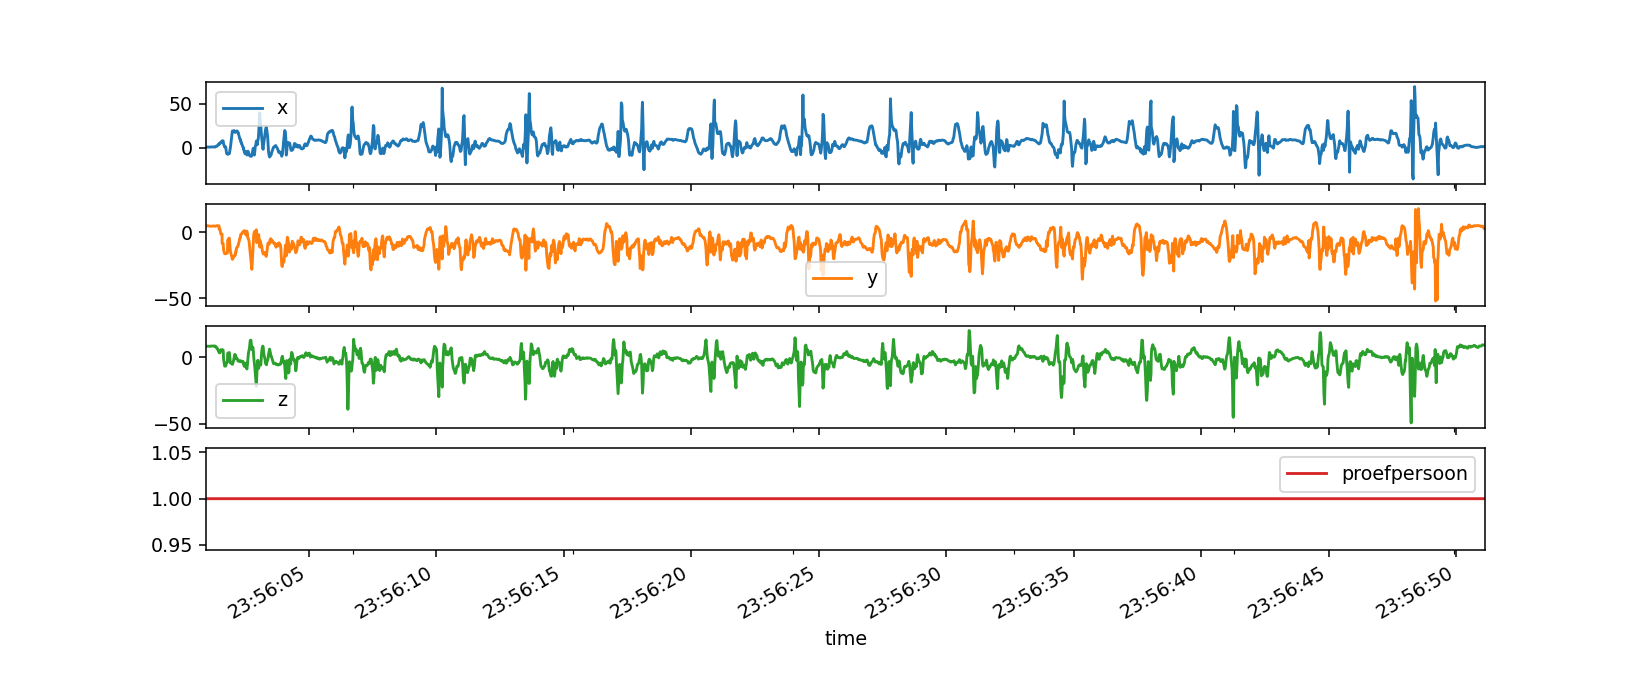

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000245F1F8C588>,
      dtype=object)

In [43]:
plt.figsize=(8,5)
backward_180_right_righta.plot(x='time', subplots=True)

In [68]:
backward_180_right_right_1 = [backward_180_right_righta, backward_180_right_rightb]

In [69]:
for df in backward_180_right_right_1:
    f = sampling_freq(df)
    freq += f

#### backward_180_left_left

#### tussenpauze

In [ ]:
#8 segmenten
forward_180_left_backwards_other1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_left_backwards_tim_other_side1.csv", sep=';', header=0, skipinitialspace=True)

In [ ]:
f1 =  forward_180_left_backwards_other1[forward_180_left_backwards_other1["time"] <= 32379000000000]
f2 =  forward_180_left_backwards_other1[(forward_180_left_backwards_other1["time"] >= 32379000000000) & (forward_180_left_backwards_other1["time"] <= 32383100000000)]
f3 =  forward_180_left_backwards_other1[(forward_180_left_backwards_other1["time"] >= 32383100000000) & (forward_180_left_backwards_other1["time"] <= 32387300000000)]
f4 =  forward_180_left_backwards_other1[(forward_180_left_backwards_other1["time"] >= 32387300000000) & (forward_180_left_backwards_other1["time"] <= 32391400000000)]
f5 =  forward_180_left_backwards_other1[(forward_180_left_backwards_other1["time"] >= 32391400000000) & (forward_180_left_backwards_other1["time"] <= 32395500000000)]
f6 =  forward_180_left_backwards_other1[(forward_180_left_backwards_other1["time"] >= 32395500000000) & (forward_180_left_backwards_other1["time"] <= 32399600000000)]
f7 =  forward_180_left_backwards_other1[(forward_180_left_backwards_other1["time"] >= 32399600000000) & (forward_180_left_backwards_other1["time"] <= 32403800000000)]
f8 =  forward_180_left_backwards_other1[(forward_180_left_backwards_other1["time"] >= 32403800000000) & (forward_180_left_backwards_other1["time"] <= 32408100000000)]


In [ ]:
f1 = preprocess(f1, "backward_180", 0.8, 0.6)
f2 = preprocess(f2, "backward_180", 1, 0.7)
f3 = preprocess(f3, "backward_180", 1.3, 0.6)
f4 = preprocess(f4, "backward_180", 1.2, 0.6)
f5 = preprocess(f5, "backward_180", 1.1, 0.7)
f6 = preprocess(f6, "backward_180", 1.3, 0.6)
f7 = preprocess(f7, "backward_180", 1.2, 0.7)
f8 = preprocess(f8, "backward_180", 1.2, 0.7)

In [ ]:
forward_180_left_backwards_other_side_1 = [f1,f2, f3, f4, f5, f6, f7, f8]

#### zonder tussenpauzes

In [70]:
backward_180_left_lefta = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\backward_180_left_left_tim1.csv", 
    sep=';', header=0, skipinitialspace=True)


In [71]:
backward_180_left_lefta = preprocess(backward_180_left_lefta, "backward_180", "left_left", 1)

In [72]:
backward_180_left_left_1 = [backward_180_left_lefta]

In [73]:
for df in backward_180_left_left_1:
    f = sampling_freq(df)
    freq += f

#### backward_180_right_left

#### tussenpauze

In [ ]:
#7 SEGMENTEN
forward_180_right_backwards_other1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_backwards_other_side_tim1.csv", sep=';', header=0, skipinitialspace=True)
#1 SEGMENT
forward_180_right_backwards_other2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\forward_180_right_backwards_other_side_tim2.csv", sep=';', header=0, skipinitialspace=True)


In [ ]:
f1 =  forward_180_right_backwards_other1[forward_180_right_backwards_other1["time"] <= 31867200000000]
f2 =  forward_180_right_backwards_other1[(forward_180_right_backwards_other1["time"] >= 31867200000000) & (forward_180_right_backwards_other1["time"] <= 31871500000000)]
f3 =  forward_180_right_backwards_other1[(forward_180_right_backwards_other1["time"] >= 31871500000000) & (forward_180_right_backwards_other1["time"] <= 31875700000000)]
f4 =  forward_180_right_backwards_other1[(forward_180_right_backwards_other1["time"] >= 31875700000000) & (forward_180_right_backwards_other1["time"] <= 31880400000000)]
f5 =  forward_180_right_backwards_other1[(forward_180_right_backwards_other1["time"] >= 31880400000000) & (forward_180_right_backwards_other1["time"] <= 31885400000000)]
f6 =  forward_180_right_backwards_other1[(forward_180_right_backwards_other1["time"] >= 31885400000000) & (forward_180_right_backwards_other1["time"] <= 31889600000000)]
f7 =  forward_180_right_backwards_other1[forward_180_right_backwards_other1["time"] >= 31889600000000]

f8 =  forward_180_right_backwards_other2[forward_180_right_backwards_other2["time"] <= 31918500000000]

In [ ]:
f1 = preprocess(f1, "backward_180", 1.8, 0.4)
f2 = preprocess(f2, "backward_180", 1.2, 0.4)
f3 = preprocess(f3, "backward_180", 1.2, 0.6)
f4 = preprocess(f4, "backward_180", 1.2, 0.6)
f5 = preprocess(f5, "backward_180", 2, 0.6)
f6 = preprocess(f6, "backward_180", 1.2, 0.6)
f7 = preprocess(f7, "backward_180", 1.2, 4.8)
f8 = preprocess(f8, "backward_180", 1.5, 0.5)

In [ ]:
forward_180_right_backwards_other_side_1 = [f1,f2, f3, f4, f5, f6, f7, f8]

#### zonder tussenpauzes

In [74]:
backward_180_right_lefta = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\backward_180_right_left_tim1.csv", 
    sep=';', header=0, skipinitialspace=True)

backward_180_right_leftb = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon1\backward_180_right_left_tim2.csv", 
    sep=';', header=0, skipinitialspace=True)

In [75]:
backward_180_right_lefta = preprocess(backward_180_right_lefta, "backward_180", "right_left",1, 3, 4)
backward_180_right_leftb = preprocess(backward_180_right_leftb, "backward_180", "right_left",1)

In [76]:
backward_180_right_left_1 = [backward_180_right_lefta, backward_180_right_leftb]

In [77]:
for df in backward_180_right_left_1:
    f = sampling_freq(df)
    freq += f

### SEGMENTATION

In [78]:
if( not raw):
    #segmentation + feature extraction
    for i in range(0, len(backward_180_left_right_1)):
        backward_180_left_right_1[i] =  feature_extraction_segmentation(backward_180_left_right_1[i],1, True)

    for i in range(0, len(backward_180_right_right_1)):
        backward_180_right_right_1[i] =  feature_extraction_segmentation(backward_180_right_right_1[i],1, True)

    for i in range(0, len(backward_180_left_left_1)):
        backward_180_left_left_1[i] =  feature_extraction_segmentation(backward_180_left_left_1[i],1, True)
    
    for i in range(0, len(backward_180_right_left_1)):
        backward_180_right_left_1[i] =  feature_extraction_segmentation(backward_180_right_left_1[i],1, True)

In [79]:
backward_180_left_right_1 = pd.concat(backward_180_left_right_1, ignore_index=True)
backward_180_left_right_1.shape

(2706, 7)

In [80]:
backward_180_right_right_1 = pd.concat(backward_180_right_right_1, ignore_index=True)
backward_180_right_right_1.shape

(3226, 7)

In [81]:
backward_180_left_left_1 = pd.concat(backward_180_left_left_1, ignore_index=True)
backward_180_left_left_1.shape

(3017, 7)

In [82]:
backward_180_right_left_1 = pd.concat(backward_180_right_left_1, ignore_index=True)
backward_180_right_left_1.shape

(3865, 7)

### SHUFFLE - BALANCING

In [83]:
shape = np.min([
    backward_180_left_right_1.shape[0], 
    backward_180_right_right_1.shape[0], 
    backward_180_left_left_1.shape[0], 
    backward_180_right_left_1.shape[0]])
shape

2706

#### shuffle

In [29]:
backward_180_left_right_1 = shuffle(backward_180_left_right_1).head(shape).copy()
backward_180_right_right_1 = shuffle(backward_180_right_right_1).head(shape).copy()
backward_180_left_left_1 = shuffle(backward_180_left_left_1).head(shape).copy()
backward_180_right_left_1 = shuffle(backward_180_right_left_1).head(shape).copy()

#### no shuffle

In [84]:
backward_180_left_right_1 = backward_180_left_right_1.head(shape).copy()
backward_180_right_right_1 = backward_180_right_right_1.head(shape).copy()
backward_180_left_left_1 = backward_180_left_left_1.head(shape).copy()
backward_180_right_left_1 = backward_180_right_left_1.head(shape).copy()

In [85]:
backward_180_1 = pd.concat([backward_180_left_right_1, backward_180_right_right_1, backward_180_left_left_1, backward_180_right_left_1])

# <font color='green' >PROEFPERSOON 2

## backward 180

In [86]:
backward_180_left_right_2 = []
backward_180_right_right_2= []
backward_180_left_left_2 = []
backward_180_right_left_2= []

#### backward_180_left_right

#### tussenpauze

In [290]:
#7 SEGMENTEN
forward_180_left_backwards1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_left_backwards1.csv", sep=';', header=0, skipinitialspace=True)

#1 SEGMENT
forward_180_left_backwards2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_left_backwards2.csv", sep=';', header=0, skipinitialspace=True)
forward_180_left_backwards3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_left_backwards3.csv", sep=';', header=0, skipinitialspace=True)

In [292]:
f1 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] <= 11248600000000)]
f2 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 11248600000000) & (forward_180_left_backwards1["time"] <= 11253300000000)]
f3 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 11253300000000) & (forward_180_left_backwards1["time"] <= 11258300000000)]
f4 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 11258300000000) & (forward_180_left_backwards1["time"] <= 11263400000000)]
f5 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 11263400000000) & (forward_180_left_backwards1["time"] <= 11268300000000)]
f6 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 11268300000000) & (forward_180_left_backwards1["time"] <= 11273000000000)]
f7 =  forward_180_left_backwards1[(forward_180_left_backwards1["time"] >= 11273000000000)]

f8 =  forward_180_left_backwards2[(forward_180_left_backwards2["time"] <= 11287300000000)]

In [293]:
f1 = preprocess(f1, "backward_180", 1, 0.7)
f2 = preprocess(f2, "backward_180", 1, 1)
f3 = preprocess(f3, "backward_180", 1.3, 0.9)
f4 = preprocess(f4, "backward_180", 1.4, 0.9)
f5 = preprocess(f5, "backward_180", 1.2, 1)
f6 = preprocess(f6, "backward_180", 1.1, 1)
f7 = preprocess(f7, "backward_180", 1.2, 2.4)
f8 = preprocess(f8, "backward_180", 2, 1.1)

In [295]:
forward_180_left_backwards_2 = [f1, f2, f3, f4, f5, f6, f7, f8]

#### zonder tussenpauzes

In [4]:
backward_180_left_right_2a = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\backward_180_left_right.csv", 
    sep=';', header=0, skipinitialspace=True)


<IPython.core.display.Javascript object>


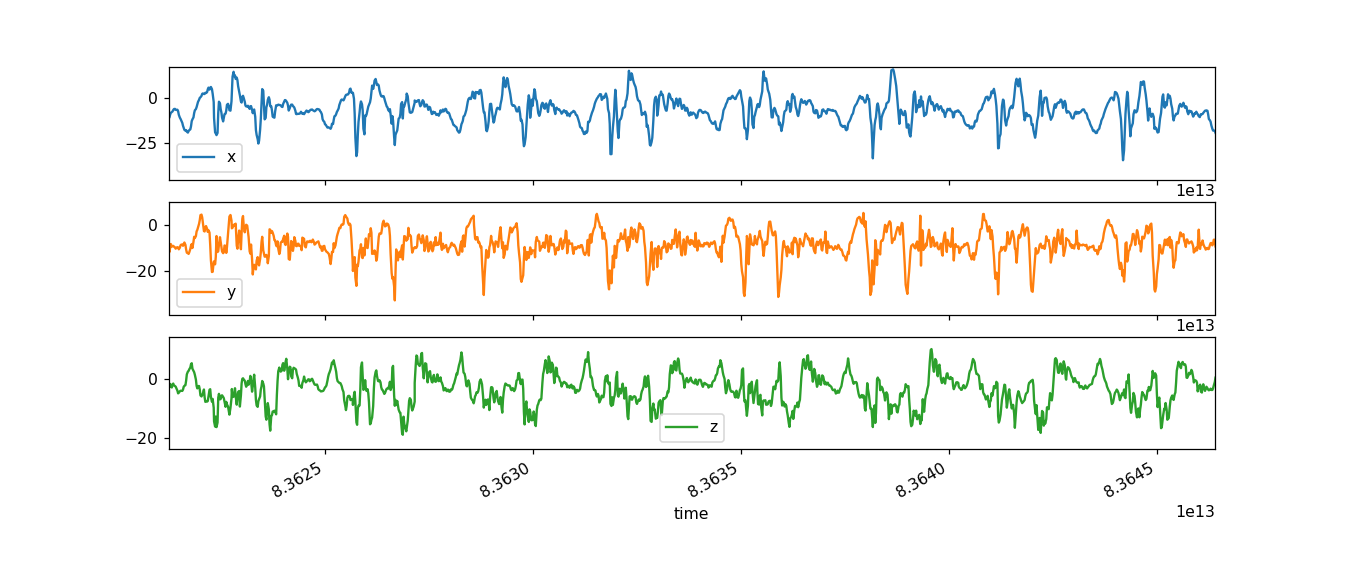

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020E443C70C8>,
      dtype=object)

In [5]:
backward_180_left_right_2a.plot(x='time', subplots=True)

In [88]:
backward_180_left_right_2a = preprocess(backward_180_left_right_2a, "backward_180", "left_right", 2)

In [89]:
backward_180_left_right_2 = [backward_180_left_right_2a]

In [90]:
for df in backward_180_left_right_2:
    f = sampling_freq(df)
    freq += f

#### zonder tussenpauzes, zonder springen

In [26]:
backward_180_nospringa = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\backward_180_left_right_nospring1.csv", 
    sep=';', header=0, skipinitialspace=True)

In [27]:
backward_180_nospringa = preprocess(backward_180_nospringa, "backward_180", "left_right",2, 0.8, 2.2)

In [36]:
backward_180_left_right_1 = [backward_180_nospringa]

In [37]:
for df in backward_180_left_right_1:
    f = sampling_freq(df)
    freq += f

#### backward_180_right_right

#### tussenpauzes

In [297]:
#4SEGMENTEN
forward_180_right_backwards2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_right_backwards2.csv", sep=';', header=0, skipinitialspace=True)
#4 SEGMENTEN
forward_180_right_backwards3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_right_backwards3.csv", sep=';', header=0, skipinitialspace=True)

In [299]:
f1 =  forward_180_right_backwards2[(forward_180_right_backwards2["time"] <= 11719400000000)]
f2 =  forward_180_right_backwards2[(forward_180_right_backwards2["time"] >= 11719400000000) & (forward_180_right_backwards2["time"] <= 11723600000000)]
f3 =  forward_180_right_backwards2[(forward_180_right_backwards2["time"] >= 11723600000000) & (forward_180_right_backwards2["time"] <= 11727900000000)]
f4 =  forward_180_right_backwards2[(forward_180_right_backwards2["time"] >= 11727900000000) ]

f5 =  forward_180_right_backwards3[(forward_180_right_backwards3["time"] >= 11736100000000) & (forward_180_right_backwards3["time"] <= 11740600000000)]
f6 =  forward_180_right_backwards3[(forward_180_right_backwards3["time"] >= 11740600000000) & (forward_180_right_backwards3["time"] <= 11744900000000)]
f7 =  forward_180_right_backwards3[(forward_180_right_backwards3["time"] >= 11744900000000) & (forward_180_right_backwards3["time"] <= 11749400000000)]
f8 =  forward_180_right_backwards3[(forward_180_right_backwards3["time"] >= 11749400000000) & (forward_180_right_backwards3["time"] <= 11754200000000)]

In [300]:
f1 = preprocess(f1, "backward_180", 0.2, 0.7)
f2 = preprocess(f2, "backward_180", 0.7, 1)
f3 = preprocess(f3, "backward_180", 0.7, 1)
f4 = preprocess(f4, "backward_180", 0.8, 1.3)
f5 = preprocess(f5, "backward_180", 1, 1.1)
f6 = preprocess(f6, "backward_180", 0.9, 0.8)
f7 = preprocess(f7, "backward_180", 0.8, 1.1)
f8 = preprocess(f8, "backward_180", 1.3, 1)

In [302]:
forward_180_right_backwards_2 = [f1, f2, f3, f4, f5, f6, f7, f8]

#### zonder tussenpauzes

In [91]:
backward_180_right_right_2a = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\backward_180_right_right1.csv", 
    sep=';', header=0, skipinitialspace=True)


In [92]:
backward_180_right_right_2a = preprocess(backward_180_right_right_2a, "backward_180", "right_right", 2)

In [93]:
backward_180_right_right_2 = [backward_180_right_right_2a]

In [94]:
for df in backward_180_right_right_2:
    f = sampling_freq(df)
    freq += f

#### zonder tussenpauzes, zonder springen

In [22]:
backward_180_right_right_nospringa = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\backward_180_right_right_nospring_handenbijelkqat.csv", 
    sep=';', header=0, skipinitialspace=True)

In [23]:
backward_180_right_right_nospringa = preprocess(backward_180_right_right_nospringa, "backward_180", "right_right",2, 5.5, 6.5)

In [36]:
backward_180_right_right_1 = [backward_180_right_right_nospringa]

In [37]:
for df in backward_180_right_right_1:
    f = sampling_freq(df)
    freq += f

#### backward_180_left_left

#### tussenpauzes

In [304]:
#8 SEGMENTEN
forward_180_left_otherside1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_left_back_otherside1.csv", sep=';', header=0, skipinitialspace=True)

In [306]:
f1 =  forward_180_left_otherside1[(forward_180_left_otherside1["time"] <= 20761300000000)]
f2 =  forward_180_left_otherside1[(forward_180_left_otherside1["time"] >= 20761300000000) & (forward_180_left_otherside1["time"] <= 20766800000000)]
f3 =  forward_180_left_otherside1[(forward_180_left_otherside1["time"] >= 20766800000000) & (forward_180_left_otherside1["time"] <= 20772100000000)]
f4 =  forward_180_left_otherside1[(forward_180_left_otherside1["time"] >= 20772100000000) & (forward_180_left_otherside1["time"] <= 20777400000000)]
f5 =  forward_180_left_otherside1[(forward_180_left_otherside1["time"] >= 20777400000000) & (forward_180_left_otherside1["time"] <= 20782700000000)]
f6 =  forward_180_left_otherside1[(forward_180_left_otherside1["time"] >= 20782700000000) & (forward_180_left_otherside1["time"] <= 20787800000000)]
f7 =  forward_180_left_otherside1[(forward_180_left_otherside1["time"] >= 20787800000000) & (forward_180_left_otherside1["time"] <= 20793100000000)]
f8 =  forward_180_left_otherside1[(forward_180_left_otherside1["time"] >= 20793100000000) & (forward_180_left_otherside1["time"] <= 20798900000000)]

In [307]:
f1 = preprocess(f1, "backward_180", 1.7, 1.1)
f2 = preprocess(f2, "backward_180", 1.6, 1.7)
f3 = preprocess(f3, "backward_180", 1.7, 1.1)
f4 = preprocess(f4, "backward_180", 1.7, 1.1)
f5 = preprocess(f5, "backward_180", 1.8, 1.2)
f6 = preprocess(f6, "backward_180", 1.5, 1.3)
f7 = preprocess(f7, "backward_180", 1.5, 1.3)
f8 = preprocess(f8, "backward_180", 1.8, 1.5)

In [309]:
forward_180_left_other_side_2 = [f1, f2, f3, f4, f5, f6, f7, f8]

#### zonder tussenpauzes

In [95]:
backward_180_left_left_2a = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\backward_180_left_left.csv", 
    sep=';', header=0, skipinitialspace=True)


In [96]:
backward_180_left_left_2a = preprocess(backward_180_left_left_2a, "backward_180", "left_left", 2)

In [97]:
backward_180_left_left_2 = [backward_180_left_left_2a]

In [98]:
for df in backward_180_left_left_2:
    f = sampling_freq(df)
    freq += f

#### zonder tussenpauzes, zonder springen

In [46]:
backward_180_left_left_nospringa = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\backward_180_left_left_nospring.csv", 
    sep=';', header=0, skipinitialspace=True)

In [47]:
backward_180_left_left_nospringa = preprocess(backward_180_left_left_nospringa, "backward_180", "left_left",2, 5.3, 5.5)

In [36]:
backward_180_left_left_1 = [backward_180_left_left_nospringa]

In [37]:
for df in backward_180_left_left_1:
    f = sampling_freq(df)
    freq += f

#### backward_180_right_left_2

#### tussenpauzes

In [311]:
forward_180_right_otherside1 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\forward_180_right_backwards_otherside.csv", sep=';', header=0, skipinitialspace=True)

In [313]:
f1 =  forward_180_right_otherside1[(forward_180_right_otherside1["time"] <= 21087100000000)]
f2 =  forward_180_right_otherside1[(forward_180_right_otherside1["time"] >= 21087100000000) & (forward_180_right_otherside1["time"] <= 21091500000000)]
f3 =  forward_180_right_otherside1[(forward_180_right_otherside1["time"] >= 21091500000000) & (forward_180_right_otherside1["time"] <= 21095700000000)]
f4 =  forward_180_right_otherside1[(forward_180_right_otherside1["time"] >= 21095700000000) & (forward_180_right_otherside1["time"] <= 21100000000000)]
f5 =  forward_180_right_otherside1[(forward_180_right_otherside1["time"] >= 21100000000000) & (forward_180_right_otherside1["time"] <= 21104500000000)]
f6 =  forward_180_right_otherside1[(forward_180_right_otherside1["time"] >= 21104500000000) & (forward_180_right_otherside1["time"] <= 21109700000000)]
f7 =  forward_180_right_otherside1[(forward_180_right_otherside1["time"] >= 21109700000000) & (forward_180_right_otherside1["time"] <= 21115000000000)]
f8 =  forward_180_right_otherside1[(forward_180_right_otherside1["time"] >= 21115000000000) & (forward_180_right_otherside1["time"] <= 21119800000000)]

In [314]:
f1 = preprocess(f1, "backward_180", 1.3, 0.5)
f2 = preprocess(f2, "backward_180", 1, 0.7)
f3 = preprocess(f3, "backward_180", 0.8, 0.7)
f4 = preprocess(f4, "backward_180", 0.9, 0.7)
f5 = preprocess(f5, "backward_180", 1, 0.7)
f6 = preprocess(f6, "backward_180", 0.9, 1.6)
f7 = preprocess(f7, "backward_180", 1.7, 0.8)
f8 = preprocess(f8, "backward_180", 1, 0.8)

In [316]:
forward_180_right_other_side_2 = [f1, f2, f3, f4, f5, f6, f7, f8]

#### zonder tussenpauzes

In [99]:
backward_180_right_left_2a = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\backward_180_right_left1.csv", 
    sep=';', header=0, skipinitialspace=True)


In [100]:
backward_180_right_left_2a = preprocess(backward_180_right_left_2a, "backward_180", "right_left", 2)

In [101]:
backward_180_right_left_2 = [backward_180_right_left_2a]

In [102]:
for df in backward_180_right_left_2:
    f = sampling_freq(df)
    freq += f

#### zonder tussenpauzes, zonder springen

In [64]:
backward_180_right_left_nospringa = pd.read_csv(
    r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\backward_180_right_left_nospring.csv", 
    sep=';', header=0, skipinitialspace=True)

In [65]:
backward_180_right_left_nospringa = preprocess(backward_180_right_left_nospringa, "backward_180", "right_left",2, 4.5, 5)

In [36]:
backward_180_right_left_1 = [backward_180_right_left_nospringa]

In [37]:
for df in backward_180_right_left_1:
    f = sampling_freq(df)
    freq += f

### SEGMENTATION

In [103]:
if( not raw):
    #segmentation + feature extraction
    for i in range(0, len(backward_180_left_right_2)):
        backward_180_left_right_2[i] =  feature_extraction_segmentation(backward_180_left_right_2[i],1, True)

    for i in range(0, len(backward_180_right_right_2)):
        backward_180_right_right_2[i] =  feature_extraction_segmentation(backward_180_right_right_2[i],1, True)

    for i in range(0, len(backward_180_left_left_2)):
        backward_180_left_left_2[i] =  feature_extraction_segmentation(backward_180_left_left_2[i],1, True)
    
    for i in range(0, len(backward_180_right_left_2)):
        backward_180_right_left_2[i] =  feature_extraction_segmentation(backward_180_right_left_2[i],1, True)

In [104]:
backward_180_left_right_2 = pd.concat(backward_180_left_right_2, ignore_index=True)
backward_180_left_right_2.shape

(2840, 7)

In [105]:
backward_180_right_right_2 = pd.concat(backward_180_right_right_2, ignore_index=True)
backward_180_right_right_2.shape

(3823, 7)

In [106]:
backward_180_left_left_2 = pd.concat(backward_180_left_left_2, ignore_index=True)
backward_180_left_left_2.shape

(3036, 7)

In [107]:
backward_180_right_left_2 = pd.concat(backward_180_right_left_2, ignore_index=True)
backward_180_right_left_2.shape

(4437, 7)

### SHUFFLE - BALANCING

In [108]:
shape = np.min([
    backward_180_left_right_2.shape[0], 
    backward_180_right_right_2.shape[0], 
    backward_180_left_left_2.shape[0], 
    backward_180_right_left_2.shape[0]])

#### shuffle

In [53]:
backward_180_left_right_2 = shuffle(backward_180_left_right_2).head(shape).copy()
backward_180_right_right_2 = shuffle(backward_180_right_right_2).head(shape).copy()
backward_180_left_left_2 = shuffle(backward_180_left_left_2).head(shape).copy()
backward_180_right_left_2 = shuffle(backward_180_right_left_2).head(shape).copy()

#### no shuffle

In [109]:
backward_180_left_right_2 = backward_180_left_right_2.head(shape).copy()
backward_180_right_right_2 = backward_180_right_right_2.head(shape).copy()
backward_180_left_left_2 = backward_180_left_left_2.head(shape).copy()
backward_180_right_left_2 = backward_180_right_left_2.head(shape).copy()

In [110]:
backward_180_2 = pd.concat([
    backward_180_left_right_2, 
    backward_180_right_right_2, 
    backward_180_left_left_2, 
    backward_180_right_left_2])

# <font color='green'> Frequency

In [55]:
#mean
freq = freq/64
freq

8.09065359749383

# <font color='green'> Merging datasets

In [111]:
shape = np.min([
    backward_180_1.shape[0],
    backward_180_2.shape[0]
])

#### shuffle

In [56]:
dataset = pd.concat([
    shuffle(backward_180_1).head(shape),
    shuffle(backward_180_2).head(shape)
])
dataset.shape

(832, 22)

#### no shuffle

In [112]:
dataset = pd.concat([
    backward_180_1.head(shape),
    backward_180_2.head(shape)
])
dataset.shape

(21648, 7)

In [113]:
dataset.to_csv("backward_180_zonder_pauze_raw.csv", sep=';')